In [1]:
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import glob
from scipy.signal import butter, lfilter, freqz
%matplotlib inline

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = .5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b,a = butter(order, [low,high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b,a = butter_bandpass(lowcut, highcut, fs, order=order)
    y=lfilter(b, a, data)
    return y



In [3]:
datafiles= glob.glob('../train/subj1_series1_*.csv')
print datafiles

['../train/subj1_series1_data.csv', '../train/subj1_series1_events.csv']


In [110]:
data_tbl = pd.read_csv(datafiles[0]); events_tbl = pd.read_csv(datafiles[-1])
fdata_tbl = data_tbl.copy(); #store processed data here
print data_tbl.keys()
print events_tbl.keys()

Index([u'id', u'Fp1', u'Fp2', u'F7', u'F3', u'Fz', u'F4', u'F8', u'FC5',
       u'FC1', u'FC2', u'FC6', u'T7', u'C3', u'Cz', u'C4', u'T8', u'TP9',
       u'CP5', u'CP1', u'CP2', u'CP6', u'TP10', u'P7', u'P3', u'Pz', u'P4',
       u'P8', u'PO9', u'O1', u'Oz', u'O2', u'PO10'],
      dtype='object')
Index([u'id', u'HandStart', u'FirstDigitTouch', u'BothStartLoadPhase',
       u'LiftOff', u'Replace', u'BothReleased'],
      dtype='object')


In [111]:
#get rid of pesky id, just repeats same subj#_trial#
fdata_tbl.drop('id',axis=1,inplace=True) 
events_tbl.drop('id',axis=1,inplace=True) 

In [112]:
#low band pass filter all channels
fs = 500 #Hz
lowcut = 2 #Hz
highcut = 8 #Hz
# b, a = butter_bandpass(lowcut, highcut, fs, order=4)
# w, h = freqz(b, a, worN=2000)
# plt.plot((fs * .5/n.pi) * w, abs(h))
# plt.xlim(0,20)
for k in fdata_tbl.keys():
    fdata_tbl[k] = butter_bandpass_filter(fdata_tbl[k], lowcut, highcut, fs, order=4)

In [92]:
#average same event types together
def ensemble_avg(chan_data, event):
    ans = n.zeros(150)
    index = 0
    cnt = 0
    while True:
        index_arr = n.where(event[index:] == 1)[0]
        if len(index_arr) == 0: break
        index+= index_arr[0]
#         print event[index-1],event[index],'    ', event[index+149],event[index+150]
        ans=ans + chan_data.values[index:index+150]
        index+= 150 #set to next 0 in array, now can look for next 1
        cnt+=1
    return ans/cnt

averages = {}
for chan in fdata_tbl.keys(): 
    print "chan= ",chan
    averages[chan] = {}
    for event in events_tbl.keys():
        print "event= ",event
        averages[chan][event]= ensemble_avg(fdata_tbl[chan], events_tbl[event])

SyntaxError: 'break' outside loop (<ipython-input-92-611c22883ae0>, line 19)

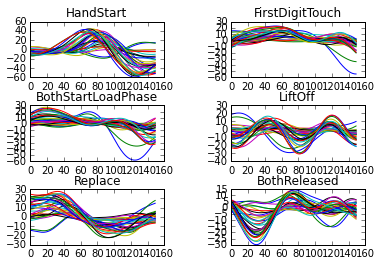

In [38]:
#covert averages dict to 2D numpy array
#6 events x 32 channels each with 150 time points
#(timepts,chan,events) ordering b/c python PCA example used this ordering
shape= (150,fdata_tbl.keys().shape[0],events_tbl.keys().shape[0],) 
avg_arr=n.zeros(shape)
#plot and store in avg_arr
fig,axis=plt.subplots(3,2)
plt.subplots_adjust(hspace=0.5,wspace=0.5)
ax=axis.flatten()
for ev_cnt,event in enumerate(events_tbl.keys()):
    ax[ev_cnt].set_title(event)
    for ch_cnt,chan in enumerate(fdata_tbl.keys()):
        ax[ev_cnt].plot(averages[chan][event])
        avg_arr[:,ch_cnt,ev_cnt]= averages[chan][event]

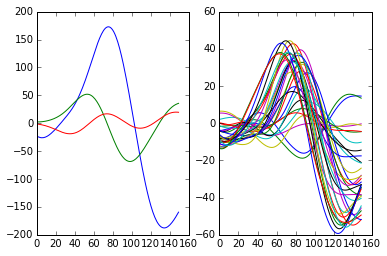

In [77]:
#PCA on numpy array
test= avg_arr.copy()[:,:,0]
# test.shape
pca = PCA(n_components=test.shape[1])
K= pca.fit_transform(test)
keep= n.where(pca.explained_variance_ratio_ >= 0.005)[0]
K= K[:,keep]
fig,axis=plt.subplots(1,2)
ax=axis.flatten()
ax[0].plot(-K)
ax[1].plot(test)

(150, 3)


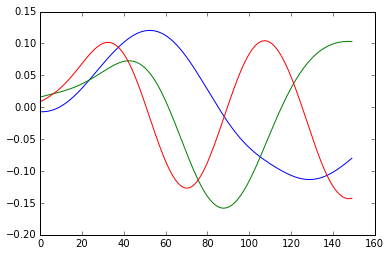

In [86]:
#ICA on numpy array
ica = FastICA(n_components=K.shape[1])
demixing = ica.fit_transform(K)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
plt.plot(demixing)
print demixing.shape
# plt.plot(A_)

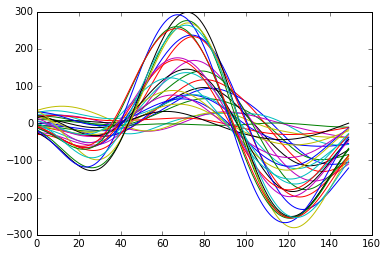

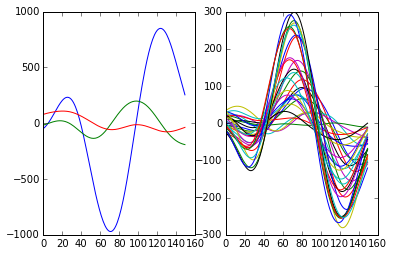

In [124]:
def ensemble_avg_1st(chan_data, event):
    index=0
    index_arr = n.where(event[index:] == 1)[0]
    index+= index_arr[0]
    #         print event[index-1],event[index],'    ', event[index+149],event[index+150]
    return chan_data.values[index:index+150]

def ensemble_avg_noise(chan_data, event):
    index=0
    index_arr = n.where(event[index:] == 1)[0]
    index+= index_arr[0]
    #         print event[index-1],event[index],'    ', event[index+149],event[index+150]
    return chan_data.values[index-300:index-150]


shape=(150,fdata_tbl.keys().shape[0])
ex = n.zeros(shape)
noise= n.zeros(shape)
event= 'HandStart'
for cnt,chan in enumerate(fdata_tbl.keys()): 
    ex[:,cnt]= ensemble_avg_1st(fdata_tbl[chan], events_tbl[event])
    noise[:,cnt]= ensemble_avg_noise(fdata_tbl[chan], events_tbl[event])
    plt.plot(ex[:,cnt])
    

pca = PCA(n_components=ex.shape[1])
K= pca.fit_transform(ex)
keep= n.where(pca.explained_variance_ratio_ >= 0.005)[0]
K= K[:,keep]
fig,axis=plt.subplots(1,2)
ax=axis.flatten()
ax[0].plot(-K)
ax[1].plot(ex)


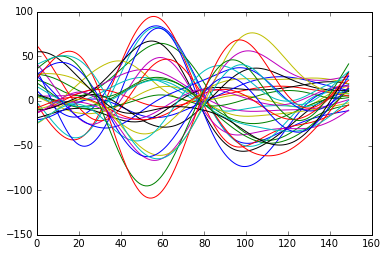

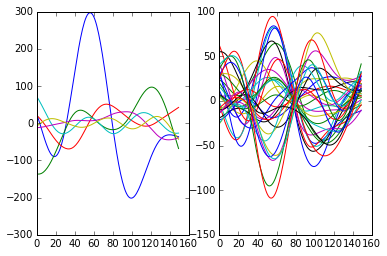

In [126]:
plt.plot(noise)
pca = PCA(n_components=ex.shape[1])
K= pca.fit_transform(noise)
keep= n.where(pca.explained_variance_ratio_ >= 0.005)[0]
K= K[:,keep]
fig,axis=plt.subplots(1,2)
ax=axis.flatten()
ax[0].plot(-K)
ax[1].plot(noise)

In [42]:
#ICA on PCA components
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
plt.plot(S_)
plt.plot(A_)
# We can `prove` that the ICA model applies by reverting the unmixing.
assert n.allclose(X, n.dot(S_, A_.T) + ica.mean_)


(150, 32)

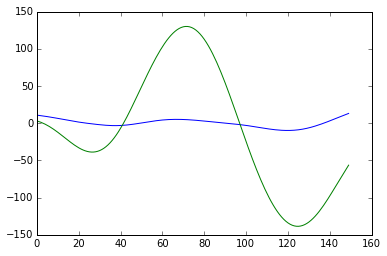

In [137]:
plt.plot(n.average(noise,axis=1))
plt.plot(n.average(ex,axis=1))

event=  HandStart
chan=  Fp1
chan=  Fp2
chan=  F7
chan=  F3
chan=  Fz
chan=  F4
chan=  F8
chan=  FC5
chan=  FC1
chan=  FC2
chan=  FC6
chan=  T7
chan=  C3
chan=  Cz
chan=  C4
chan=  T8
chan=  TP9
chan=  CP5
chan=  CP1
chan=  CP2
chan=  CP6
chan=  TP10
chan=  P7
chan=  P3
chan=  Pz
chan=  P4
chan=  P8
chan=  PO9
chan=  O1
chan=  Oz
chan=  O2
chan=  PO10
event=  FirstDigitTouch
chan=  Fp1
chan=  Fp2
chan=  F7
chan=  F3
chan=  Fz
chan=  F4
chan=  F8
chan=  FC5
chan=  FC1
chan=  FC2
chan=  FC6
chan=  T7
chan=  C3
chan=  Cz
chan=  C4
chan=  T8
chan=  TP9
chan=  CP5
chan=  CP1
chan=  CP2
chan=  CP6
chan=  TP10
chan=  P7
chan=  P3
chan=  Pz
chan=  P4
chan=  P8
chan=  PO9
chan=  O1
chan=  Oz
chan=  O2
chan=  PO10
event=  BothStartLoadPhase
chan=  Fp1
chan=  Fp2
chan=  F7
chan=  F3
chan=  Fz
chan=  F4
chan=  F8
chan=  FC5
chan=  FC1
chan=  FC2
chan=  FC6
chan=  T7
chan=  C3
chan=  Cz
chan=  C4
chan=  T8
chan=  TP9
chan=  CP5
chan=  CP1
chan=  CP2
chan=  CP6
chan=  TP10
chan=  P7
chan=  P3
chan= 

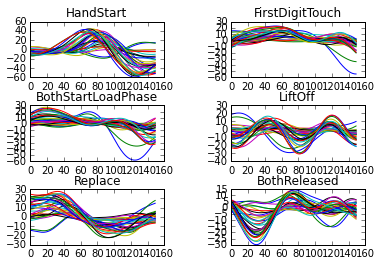

In [14]:
fig,axis=plt.subplots(3,2)
plt.subplots_adjust(hspace=0.5,wspace=0.5)
ax=axis.flatten()
for cnt,event in enumerate(events_tbl.keys()):
    print "event= ",event
    ax[cnt].set_title(event)
    for chan in fdata_tbl.keys():
        print "chan= ",chan
        ax[cnt].plot(averages[chan][event])


In [39]:
pca = PCA(n_components=3)
type(X)
pca = PCA(n_components=3)
H = pca.fit_transform(X)


numpy.ndarray

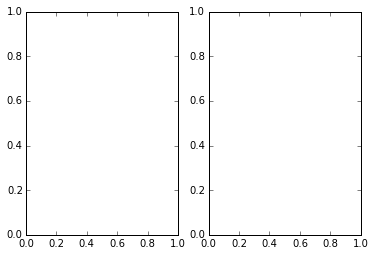

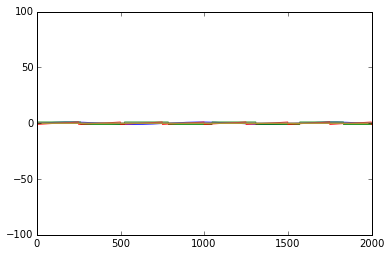

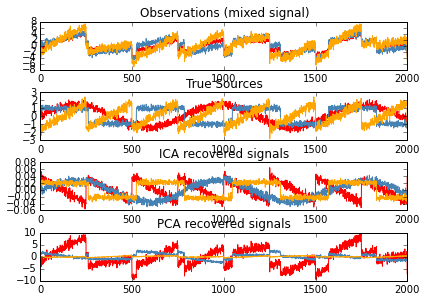

In [34]:
from sklearn.decomposition import FastICA, PCA
from scipy import signal
###############################################################################
# Generate sample data
n.random.seed(0)
n_samples = 2000
time = n.linspace(0, 8, n_samples)

s1 = n.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = n.sign(n.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * n.pi * time)  # Signal 3: saw tooth signal
plt.plot(s1)
plt.plot(s2)
plt.plot(s3)

S = n.c_[s1, s2, s3]
S += 0.2 * n.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = n.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = n.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
plt.plot(S_)
plt.plot(A_)
# We can `prove` that the ICA model applies by reverting the unmixing.
assert n.allclose(X, n.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

###############################################################################
# Plot results

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

In [33]:
H.shape

(2000, 3)

In [32]:
A_.shape,S_.shape,S.shape

((3, 3), (2000, 3), (2000, 3))